In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd

In [3]:
def perlin_generator(shape, resize_amount, scale = 5, octaves = 10, persistence = 1.9, lacunarity = 1.8):

        y, x = np.round(shape[0] / resize_amount).astype(int), np.round(shape[1] / resize_amount).astype(int)

        world = np.zeros((x, y))

        # make coordinate grid on [0,1]^2
        x_idx = np.linspace(0, 1, y)
        y_idx = np.linspace(0, 1, x)
        world_x, world_y = np.meshgrid(x_idx, y_idx)

        # apply perlin noise, instead of np.vectorize, consider using itertools.starmap()
        world = np.vectorize(noise.pnoise2)(world_x / scale,
                                            world_y / scale,
                                            octaves=octaves,
                                            persistence=persistence,
                                            lacunarity=lacunarity)

        # here was the error: one needs to normalize the image first. Could be done without copying the array, though
        img = np.floor((world + .5) * 255).astype(np.uint8)  # <- Normalize world first
        return img


In [4]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

In [5]:
raster_cell(200, 100, additional_width=40).shape

(200, 140)

In [7]:
wavelengths = [0, 0.4, 0.5, 0.6, 0.7]
def generate_PC_cell(cell_length, cell_width, additional_width, pad_amount, ID):
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_additional_width = additional_width/pix_mic_conv * resize_amount

    if not glob(f"A_B_single_cells/PC_{raster_cell_length}_{raster_cell_width}_{raster_additional_width}_0.6.png"):
        cell = raster_cell(length=raster_cell_length, width=raster_cell_width, additional_width=raster_additional_width)
        PC_cell = np.pad(cell, pad_amount).astype(np.float32)
        PC_cell += np.rot90(perlin_generator(PC_cell.shape, 1, scale = 20))/300
        PC_cell_conv = convolve_rescale(image = PC_cell, kernel = PC_PSF.kernel, rescale_factor=1/resize_amount, rescale_int=True)
        
        raster_depth = np.max(cell)
        raster_cell_length, raster_cell_width = cell.shape
        Image.fromarray(img_as_uint(PC_cell_conv)).save(f"A_B_single_cells/{ID}_PC_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_0.6.png")

def generate_FL_cell(cell_length, cell_width , additional_width, pad_amount, ID):
    
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_additional_width = additional_width/pix_mic_conv * resize_amount
    
    FL_cells = []
    for wavelength in wavelengths:
        raster_cell_length = cell_length/pix_mic_conv * resize_amount
        raster_cell_width = cell_width/pix_mic_conv * resize_amount
        raster_additional_width = additional_width/pix_mic_conv * resize_amount
        cell = raster_cell(length=raster_cell_length, width=raster_cell_width, additional_width=raster_additional_width)
        raster_depth = np.max(cell)
        raster_cell_length, raster_cell_width = cell.shape
        
        FL_cell = np.pad(cell,pad_amount).astype(np.float32)   
        
        if not glob(f"A_B_single_cells/{ID}_FL_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_{wavelength}.png"):
            if wavelength:
                FL_PSF = PSF_generator(
                    radius = radius,
                    wavelength = wavelength,
                    NA = NA,
                    n = n,
                    resize_amount = resize_amount,
                    pix_mic_conv = pix_mic_conv,
                    apo_sigma = apo_sigma,
                    mode="3d fluo",
                    condenser = "Ph3",
                    z_height = FL_cell.shape[0],
                    pz = 0.5,
                    working_distance = 170
                )
                FL_PSF.calculate_PSF()
                FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
                FL_cell_conv = convolve_rescale(image=FL_cell, kernel=FL_PSF.kernel, rescale_factor=1/resize_amount, rescale_int = False)
                
            else:
                FL_cell_conv = convolve_rescale(image=FL_cell, kernel=zero_wavelength_PSF, rescale_factor=1/resize_amount, rescale_int = False)
            np.save(f"A_B_single_cells/{ID}_FL_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_{wavelength}.npy", FL_cell_conv)
            #Image.fromarray(img_as_uint(FL_cell_conv)).save(f"A_B_single_cells/{ID}_FL_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_{wavelength}.png")


    
def generate_membrane_cell(cell_length, cell_width, additional_width, pad_amount, ID):
    

    membrane_cells = []
    for wavelength in wavelengths:
        
        raster_cell_length = cell_length/pix_mic_conv * resize_amount
        raster_cell_width = cell_width/pix_mic_conv * resize_amount
        raster_additional_width = additional_width/pix_mic_conv * resize_amount
        
        
        membrane_thickness = 0.1 #micron
        raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
        cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
        cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

        pad_1 = int((cell_1.shape[0] - cell_2.shape[0])/2)
        pad_2 = int((cell_1.shape[1] - cell_2.shape[1])/2)
        cell_2 = np.pad(cell_2, ((pad_1,pad_1), (pad_2, pad_2)))
        membrane_cell = cell_1 - cell_2

        raster_depth = np.max(cell_1)
        raster_cell_length, raster_cell_width = membrane_cell.shape
        
        membrane_cell = np.pad(membrane_cell,pad_amount).astype(np.float32) 
        

        
        if not glob(f"A_B_single_cells/{ID}_membrane_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_{wavelength}.png"):
            if wavelength:
                FL_PSF = PSF_generator(
                        radius = radius,
                        wavelength = wavelength,
                        NA = NA,
                        n = n,
                        resize_amount = resize_amount,
                        pix_mic_conv = pix_mic_conv,
                        apo_sigma = apo_sigma,
                        mode="3d fluo",
                        condenser = "Ph3",
                        z_height = membrane_cell.shape[0],
                        pz = 0.5,
                        working_distance = 170
                    )
                FL_PSF.calculate_PSF()
                FL_PSF.kernel = np.sum(FL_PSF.kernel, axis=0)
                membrane_cell_conv = convolve_rescale(image=membrane_cell, kernel=FL_PSF.kernel, rescale_factor=1/resize_amount, rescale_int = False)
            else:
                membrane_cell_conv = convolve_rescale(image=membrane_cell, kernel=zero_wavelength_PSF, rescale_factor=1/resize_amount, rescale_int = False)
            
            np.save(f"A_B_single_cells/{ID}_membrane_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_{wavelength}.npy", membrane_cell_conv)

def generate_binary_cell(cell_length, cell_width, additional_width, pad_amount, ID):
    raster_cell_length = cell_length/pix_mic_conv * resize_amount
    raster_cell_width = cell_width/pix_mic_conv * resize_amount
    raster_additional_width = additional_width/pix_mic_conv * resize_amount
    cell = raster_cell(length=raster_cell_length, width=raster_cell_width, additional_width=raster_additional_width)
    binary_image = np.pad(cell, pad_amount) > 0
    binary_image = rescale(binary_image, 1/resize_amount, anti_aliasing=False) > 0
    
    
    raster_cell_length, raster_cell_width = cell.shape
    raster_depth = np.max(cell)
        
    Image.fromarray(img_as_uint(binary_image)).save(f"A_B_single_cells/{ID}_binary_{raster_cell_length}_{raster_cell_width}_{raster_depth}_{raster_additional_width}_0.6.png")
    
    #return binary_image

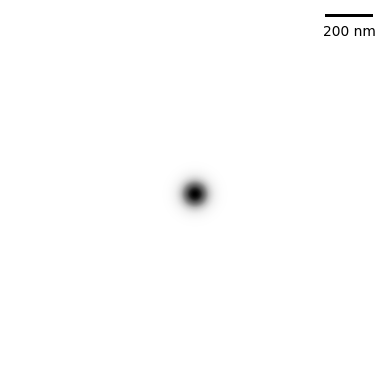

In [8]:
zero_wavelength_PSF = np.array([[0,0,0],[0,1,0],[0,0,0]])
pad_amount = 400

radius = 200
wavelength = 0.65
NA = 1.45
n = 1.518
resize_amount = 1
pix_mic_conv = 0.065 / 17
apo_sigma = 11

PC_PSF = PSF_generator(
    radius = radius,
    wavelength = wavelength,
    NA = NA,
    n = n,
    resize_amount = resize_amount,
    pix_mic_conv = pix_mic_conv,
    apo_sigma = apo_sigma,
    mode="phase contrast",
    condenser = "Ph3",
    offset=0.00000000225
)
PC_PSF.calculate_PSF()
PC_PSF.plot_PSF()

In [9]:
cell_length = (6,)
grid_size = 30
max_width = 3.1
cell_width = np.linspace(0.5, max_width, grid_size)
additional_widths = np.arange(0, 3, np.diff(cell_width)[0]).tolist() + (-np.arange(0, 3, np.diff(cell_width)[0])).tolist()
additional_widths = additional_widths + [0]
tolerance = 0.1
param_space = []
widths = []
ID = 0
for length in cell_length:
    for width in cell_width:
        if length >= width:
            for additional_width in additional_widths:
                if (width + abs(additional_width)) <= (max_width + max_width * tolerance):
                    param_space.append([length, width, additional_width, ID])
                    ID += 1
print(len(param_space))

1140


In [10]:
try:
    os.mkdir("A_B_single_cells_thick_membrane/")
except:
    pass

In [11]:
_ = Parallel(n_jobs=-1)(delayed(generate_binary_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))

  0%|          | 0/1140 [00:00<?, ?it/s]

In [12]:
timeout = 999999999
_ = Parallel(n_jobs=-1, timeout = timeout)(delayed(generate_FL_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))

  0%|          | 0/1140 [00:00<?, ?it/s]

/home/georgeos/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [13]:
_ = Parallel(n_jobs=14)(delayed(generate_membrane_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))

  0%|          | 0/1140 [00:00<?, ?it/s]

In [14]:
#_ = Parallel(n_jobs=-1)(delayed(generate_PC_cell)(length, width, additional_width,  pad_amount, ID) for length, width, additional_width, ID in tqdm(param_space))